# MNIST classification example with TensorFlow

## Needed librairies

In [81]:
import tensorflow as tf
#from keras.datasets import mnist
#import keras
import numpy as np
import matplotlib.pyplot as plt
#from keras.datasets import mnist
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
#from keras.utils import np_utils

In [40]:
tf.__version__

'1.11.0'

## Import the Data

In [43]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
# with AXA network
import gzip
import sys
import _pickle as cPickle
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [44]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [45]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [46]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [47]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [48]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [49]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [50]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [51]:
x_train.shape

(60000, 784)

In [52]:
x_test.shape

(10000, 784)

## Reshape the labels

In [53]:
y_train.shape

(60000,)

In [54]:
y_test.shape

(10000,)

In [55]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [56]:
num_classes = len(np.unique(y_train))
num_classes

10

In [57]:
y_train_ = np.zeros((len(y_train), num_classes))
y_test_ = np.zeros((len(y_test), num_classes))

In [58]:
y_train_[np.arange(len(y_train)), y_train] = 1
y_test_[np.arange(len(y_test)), y_test] = 1

In [59]:
y_train=y_train_
y_test=y_test_

In [60]:
y_train.shape

(60000, 10)

In [61]:
y_test.shape

(10000, 10)

In [62]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

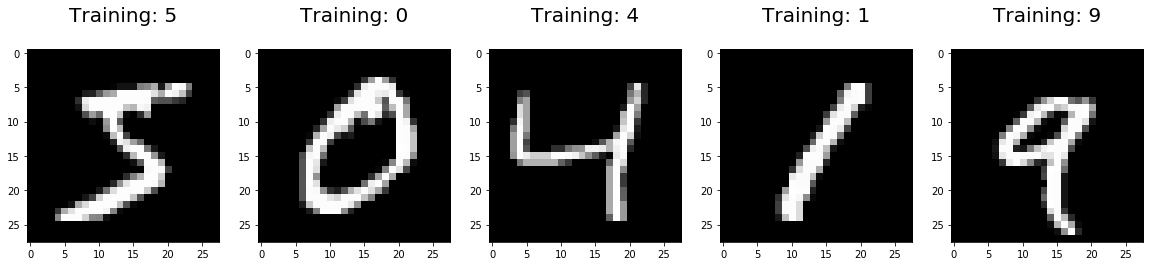

In [63]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Using tf.data.Dataset

In [143]:
def input_dataset_fn(x_data, y_data, is_training=True, batch_size=1024):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    if is_training:
        dataset = dataset.shuffle(1000) # depends on sample size
        #dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
        
    # caching data
    dataset = dataset.cache()
    
    # create batches of data
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    # automatically refill the data queue when empty
    dataset = dataset.repeat()
    
    # prefetch data for faster consumption
    # based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
    dataset = dataset.prefetch(tf.contrib.data.AUTOTUNE)

    return dataset

In [147]:
training_dataset = input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE)
testing_dataset = input_dataset_fn(x_test, y_test, is_training=False, batch_size=BATCH_SIZE)

## Defined some hyperparameters

In [146]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
EPOCHS = 10

# size of our mini batch
BATCH_SIZE = 200

# hidden layer 1
n1=300

In [125]:
class UDFPrint(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return
        

## Defined our model

In [126]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(dim_input, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    # optimiser
    optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
    # GD/SGC: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # Adam: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # RMSProp: keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [127]:
# build the model
model = baseline_model()

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


## Fit the model using numpy array

In [152]:
# Fit the model
model.fit(x_train, 
          y_train, 
          validation_data=(x_test, y_test),
          #callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=2)

Train on 60000 samples, validate on 10000 samples
Reached epoch   0 cost J = 0.02786
Epoch 1/10
 accurary on the training set 0.9962
 accurary on the testing set 0.9772
 - 8s - loss: 0.0324 - acc: 0.9953 - val_loss: 0.2411 - val_acc: 0.9772
Reached epoch   1 cost J = 0.02716
Epoch 2/10
 accurary on the training set 0.9960
 accurary on the testing set 0.9766
 - 7s - loss: 0.0378 - acc: 0.9945 - val_loss: 0.2431 - val_acc: 0.9766
Reached epoch   2 cost J = 0.02771
Epoch 3/10
 accurary on the training set 0.9960
 accurary on the testing set 0.9748
 - 7s - loss: 0.0360 - acc: 0.9949 - val_loss: 0.2797 - val_acc: 0.9748
Reached epoch   3 cost J = 0.03006
Epoch 4/10
 accurary on the training set 0.9963
 accurary on the testing set 0.9766
 - 7s - loss: 0.0275 - acc: 0.9960 - val_loss: 0.2513 - val_acc: 0.9766
Reached epoch   4 cost J = 0.02828
Epoch 5/10
 accurary on the training set 0.9959
 accurary on the testing set 0.9755
 - 7s - loss: 0.0319 - acc: 0.9959 - val_loss: 0.2645 - val_acc: 0.

In [156]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.28440815210749376
Test accuracy: 0.9772


In [157]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.038224651398435255
Train accuracy: 0.99615


## Fit the model using data.dataset

In [153]:
# Fit the model (using data.Dataset)
model.fit(training_dataset.make_one_shot_iterator(),
          steps_per_epoch=len(x_train) // BATCH_SIZE,
          validation_data=testing_dataset.make_one_shot_iterator(),
          validation_steps=len(x_test) // BATCH_SIZE,
          #callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
          epochs=EPOCHS,
          verbose = 2)

Reached epoch   0 cost J = 0.01916
Epoch 1/10
 accurary on the training set 0.9951
 accurary on the testing set 0.9773
 - 113s - loss: 0.0268 - acc: 0.9965 - val_loss: 0.2787 - val_acc: 0.9773
Reached epoch   1 cost J = 0.03902
Epoch 2/10
 accurary on the training set 0.9951
 accurary on the testing set 0.9784
 - 59s - loss: 0.0435 - acc: 0.9950 - val_loss: 0.2548 - val_acc: 0.9784
Reached epoch   2 cost J = 0.04052
Epoch 3/10
 accurary on the training set 0.9965
 accurary on the testing set 0.9775
 - 48s - loss: 0.0310 - acc: 0.9962 - val_loss: 0.2591 - val_acc: 0.9775
Reached epoch   3 cost J = 0.02900
Epoch 4/10
 accurary on the training set 0.9960
 accurary on the testing set 0.9763
 - 47s - loss: 0.0357 - acc: 0.9958 - val_loss: 0.2805 - val_acc: 0.9763
Reached epoch   4 cost J = 0.03394
Epoch 5/10
 accurary on the training set 0.9937
 accurary on the testing set 0.9746
 - 47s - loss: 0.0379 - acc: 0.9954 - val_loss: 0.3150 - val_acc: 0.9746
Reached epoch   5 cost J = 0.05580
Epoc

In [154]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.28440815210749376
Test accuracy: 0.9772


In [155]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.038224651398435255
Train accuracy: 0.99615


## Fit the model using data.dataset

In [158]:
# transfor keras model to estimator model
estimator_model = tf.keras.estimator.model_to_estimator(keras_model=model)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/l7/00kxfwvs0vbbqxtrp3rpf3yh0000gn/T/tmp8o0pmugb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x139f1dd68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [160]:
estimator_model.train(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/var/folders/l7/00kxfwvs0vbbqxtrp3rpf3yh0000gn/T/tmp8o0pmugb/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('/var/folders/l7/00kxfwvs0vbbqxtrp3rpf3yh0000gn/T/tmp8o0pmugb/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense_4/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_4/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_5/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_5/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/iterations; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/lr; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/beta_1; prev_var

INFO:tensorflow:loss = 1.2516975e-07, step = 0 (1.513 sec)
INFO:tensorflow:loss = 0.008352298, step = 0 (1.599 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.577 sec)
INFO:tensorflow:loss = 1.7402497e-05, step = 0 (1.650 sec)
INFO:tensorflow:loss = 0.05151017, step = 0 (1.542 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.617 sec)


INFO:tensorflow:loss = 1.2278556e-07, step = 0 (1.614 sec)
INFO:tensorflow:loss = 0.0806077, step = 0 (1.674 sec)
INFO:tensorflow:loss = 1.0756575e-06, step = 0 (1.689 sec)
INFO:tensorflow:loss = 0.06141058, step = 0 (1.703 sec)
INFO:tensorflow:loss = 0.08113214, step = 0 (1.840 sec)
INFO:tensorflow:loss = 1.2993814e-07, step = 0 (1.728 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.045 sec)
INFO:tensorflow:loss = 0.054535545, step = 0 (2.282 sec)
INFO:tensorflow:loss = 0.02528003, step = 0 (2.005 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.719 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.809 sec)
INFO:tensorflow:loss = 0.0017172359, step = 0 (1.817 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.117 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (2.307 sec)
INFO:tensorflow:loss = 1.2159347e-07, step = 0 (1.991 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.731 sec)
INFO:tensorflow:loss = 3.7984332e-06, step = 0 (1.896 sec)
INFO:tensorflow:loss = 0.16339344, step = 0 (1.808 sec)


INFO:tensorflow:loss = 0.0001757741, step = 0 (1.962 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.662 sec)
INFO:tensorflow:loss = 1.3012201e-05, step = 0 (4.055 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (4.597 sec)
INFO:tensorflow:loss = 0.11561655, step = 0 (2.087 sec)


INFO:tensorflow:loss = 0.065431885, step = 0 (1.814 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.914 sec)
INFO:tensorflow:loss = 0.023505243, step = 0 (1.883 sec)
INFO:tensorflow:loss = 0.08074327, step = 0 (2.236 sec)
INFO:tensorflow:loss = 0.011690983, step = 0 (1.863 sec)
INFO:tensorflow:loss = 0.013630679, step = 0 (1.815 sec)


INFO:tensorflow:loss = 0.080590576, step = 0 (1.687 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.788 sec)
INFO:tensorflow:loss = 0.107935, step = 0 (1.705 sec)
INFO:tensorflow:loss = 1.9729185e-07, step = 0 (2.080 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.781 sec)
INFO:tensorflow:loss = 0.08061378, step = 0 (1.759 sec)


INFO:tensorflow:loss = 0.080590576, step = 0 (1.758 sec)
INFO:tensorflow:loss = 0.085731305, step = 0 (1.851 sec)
INFO:tensorflow:loss = 1.3887886e-07, step = 0 (1.772 sec)
INFO:tensorflow:loss = 0.009958247, step = 0 (1.939 sec)
INFO:tensorflow:loss = 0.005894153, step = 0 (1.774 sec)
INFO:tensorflow:loss = 3.168008e-07, step = 0 (1.915 sec)


INFO:tensorflow:loss = 0.06582723, step = 0 (1.950 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.964 sec)
INFO:tensorflow:loss = 0.009613352, step = 0 (1.930 sec)
INFO:tensorflow:loss = 0.08059726, step = 0 (1.940 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.818 sec)
INFO:tensorflow:loss = 0.080700666, step = 0 (1.926 sec)


INFO:tensorflow:loss = 0.080597974, step = 0 (1.870 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.324 sec)
INFO:tensorflow:loss = 5.557514e-06, step = 0 (3.203 sec)
INFO:tensorflow:loss = 0.00016756996, step = 0 (2.746 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.040 sec)


INFO:tensorflow:loss = 5.978559e-07, step = 0 (2.222 sec)
INFO:tensorflow:loss = 0.078916654, step = 0 (1.928 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.916 sec)
INFO:tensorflow:loss = 0.001121619, step = 0 (1.695 sec)
INFO:tensorflow:loss = 0.0809147, step = 0 (1.773 sec)
INFO:tensorflow:loss = 1.3142827e-07, step = 0 (1.719 sec)


INFO:tensorflow:loss = 0.089795925, step = 0 (1.759 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.790 sec)
INFO:tensorflow:loss = 0.033340782, step = 0 (1.834 sec)
INFO:tensorflow:loss = 0.0086196475, step = 0 (1.772 sec)
INFO:tensorflow:loss = 0.0569283, step = 0 (1.633 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (1.672 sec)


INFO:tensorflow:loss = 0.12320453, step = 0 (1.653 sec)
INFO:tensorflow:loss = 0.00344501, step = 0 (1.671 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.748 sec)
INFO:tensorflow:loss = 0.100819275, step = 0 (1.684 sec)
INFO:tensorflow:loss = 0.013570794, step = 0 (1.639 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.701 sec)


INFO:tensorflow:loss = 1.8077937e-05, step = 0 (1.750 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.751 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.977 sec)
INFO:tensorflow:loss = 1.3977294e-07, step = 0 (1.873 sec)
INFO:tensorflow:loss = 0.026336009, step = 0 (1.784 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (1.767 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.744 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.038 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.033 sec)
INFO:tensorflow:loss = 5.205451e-05, step = 0 (1.761 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.738 sec)


INFO:tensorflow:loss = 0.08059058, step = 0 (1.588 sec)
INFO:tensorflow:loss = 0.060325965, step = 0 (1.576 sec)
INFO:tensorflow:loss = 5.1052916e-07, step = 0 (1.741 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.619 sec)
INFO:tensorflow:loss = 0.029031696, step = 0 (1.637 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.609 sec)


INFO:tensorflow:loss = 0.08059058, step = 0 (1.665 sec)
INFO:tensorflow:loss = 0.042607833, step = 0 (2.301 sec)
INFO:tensorflow:loss = 3.1249772e-05, step = 0 (1.972 sec)
INFO:tensorflow:loss = 2.214039e-05, step = 0 (1.842 sec)
INFO:tensorflow:loss = 8.321318e-07, step = 0 (1.725 sec)
INFO:tensorflow:loss = 0.08059059, step = 0 (1.644 sec)


INFO:tensorflow:loss = 0.0012353804, step = 0 (1.676 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.636 sec)
INFO:tensorflow:loss = 0.0029212958, step = 0 (1.791 sec)
INFO:tensorflow:loss = 0.02853914, step = 0 (2.104 sec)
INFO:tensorflow:loss = 1.9759001e-07, step = 0 (2.670 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.493 sec)


INFO:tensorflow:loss = 0.00020902949, step = 0 (2.460 sec)
INFO:tensorflow:loss = 0.08174485, step = 0 (1.835 sec)
INFO:tensorflow:loss = 1.2516975e-07, step = 0 (1.893 sec)
INFO:tensorflow:loss = 1.6331693e-07, step = 0 (1.675 sec)
INFO:tensorflow:loss = 0.020958187, step = 0 (1.980 sec)
INFO:tensorflow:loss = 8.155684e-05, step = 0 (2.186 sec)


INFO:tensorflow:loss = 0.08059058, step = 0 (1.968 sec)
INFO:tensorflow:loss = 0.080590576, step = 0 (1.755 sec)
INFO:tensorflow:loss = 0.10887075, step = 0 (1.668 sec)
INFO:tensorflow:loss = 0.08059093, step = 0 (2.052 sec)
INFO:tensorflow:loss = 0.08059056, step = 0 (2.266 sec)


INFO:tensorflow:loss = 0.08059058, step = 0 (2.004 sec)
INFO:tensorflow:loss = 0.11132827, step = 0 (1.807 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.881 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.678 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.726 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (1.793 sec)


INFO:tensorflow:loss = 1.3649468e-07, step = 0 (2.018 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.886 sec)
INFO:tensorflow:loss = 0.10309661, step = 0 (2.164 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.212 sec)
INFO:tensorflow:loss = 1.8537088e-07, step = 0 (1.864 sec)
INFO:tensorflow:loss = 0.16118115, step = 0 (1.763 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.044 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.991 sec)
INFO:tensorflow:loss = 1.356006e-07, step = 0 (2.809 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (3.324 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (3.567 sec)
INFO:tensorflow:loss = 0.0054272665, step = 0 (3.667 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.550 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.433 sec)
INFO:tensorflow:loss = 0.00752022, step = 0 (2.031 sec)
INFO:tensorflow:loss = 4.1485708e-07, step = 0 (1.956 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.968 sec)
INFO:tensorflow:loss = 0.1894717, step = 0 (1.745 sec)


INFO:tensorflow:loss = 0.06421071, step = 0 (1.909 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.112 sec)
INFO:tensorflow:loss = 0.004543284, step = 0 (2.067 sec)
INFO:tensorflow:loss = 0.0829695, step = 0 (2.303 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.236 sec)


INFO:tensorflow:loss = 0.1632215, step = 0 (1.997 sec)
INFO:tensorflow:loss = 0.080900796, step = 0 (1.703 sec)
INFO:tensorflow:loss = 0.08971581, step = 0 (1.747 sec)
INFO:tensorflow:loss = 1.245737e-07, step = 0 (1.643 sec)
INFO:tensorflow:loss = 0.16170031, step = 0 (1.630 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.084 sec)


INFO:tensorflow:loss = 0.08059058, step = 0 (1.962 sec)
INFO:tensorflow:loss = 0.17141423, step = 0 (2.510 sec)
INFO:tensorflow:loss = 0.04319855, step = 0 (1.977 sec)
INFO:tensorflow:loss = 0.060936365, step = 0 (1.780 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.692 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.751 sec)


INFO:tensorflow:loss = 0.023159182, step = 0 (1.875 sec)
INFO:tensorflow:loss = 0.029181696, step = 0 (2.906 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.214 sec)
INFO:tensorflow:loss = 1.1980534e-07, step = 0 (1.909 sec)
INFO:tensorflow:loss = 4.836396e-05, step = 0 (1.773 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.667 sec)


INFO:tensorflow:loss = 3.0577533e-07, step = 0 (1.733 sec)
INFO:tensorflow:loss = 0.014795089, step = 0 (1.815 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.635 sec)
INFO:tensorflow:loss = 0.0805906, step = 0 (1.701 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.719 sec)
INFO:tensorflow:loss = 2.9653629e-07, step = 0 (1.723 sec)


INFO:tensorflow:loss = 0.005274339, step = 0 (1.732 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.784 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.637 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (2.129 sec)
INFO:tensorflow:loss = 0.036590744, step = 0 (2.651 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.017 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.367 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.781 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.976 sec)
INFO:tensorflow:loss = 0.08059488, step = 0 (1.873 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.690 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.834 sec)
INFO:tensorflow:loss = 0.1611944, step = 0 (1.667 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.646 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.685 sec)
INFO:tensorflow:loss = 1.2755395e-07, step = 0 (1.721 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.112 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (3.237 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (3.074 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.142 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.806 sec)
INFO:tensorflow:loss = 0.08258403, step = 0 (1.972 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.677 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.586 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.637 sec)
INFO:tensorflow:loss = 0.0024111855, step = 0 (1.761 sec)
INFO:tensorflow:loss = 1.2397766e-07, step = 0 (1.677 sec)
INFO:tensorflow:loss = 1.3351442e-07, step = 0 (1.611 sec)
INFO:tensorflow:loss = 0.07676411, step = 0 (1.708 sec)


INFO:tensorflow:loss = 1.4215713e-07, step = 0 (1.780 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.629 sec)
INFO:tensorflow:loss = 1.8209124e-05, step = 0 (1.750 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (1.736 sec)
INFO:tensorflow:loss = 0.0016739501, step = 0 (2.275 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.167 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.701 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.790 sec)
INFO:tensorflow:loss = 1.2040138e-07, step = 0 (1.791 sec)
INFO:tensorflow:loss = 0.16118105, step = 0 (1.768 sec)
INFO:tensorflow:loss = 0.17963034, step = 0 (2.480 sec)


INFO:tensorflow:loss = 1.5974061e-07, step = 0 (2.238 sec)
INFO:tensorflow:loss = 0.08111047, step = 0 (2.535 sec)
INFO:tensorflow:loss = 0.16123354, step = 0 (2.436 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.778 sec)
INFO:tensorflow:loss = 0.08222729, step = 0 (1.953 sec)
INFO:tensorflow:loss = 0.004185296, step = 0 (1.753 sec)


INFO:tensorflow:loss = 0.094748355, step = 0 (1.698 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (1.681 sec)
INFO:tensorflow:loss = 0.0025493326, step = 0 (1.776 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.843 sec)
INFO:tensorflow:loss = 0.01891673, step = 0 (2.140 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (1.774 sec)


INFO:tensorflow:loss = 1.573017e-05, step = 0 (1.970 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.699 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.937 sec)
INFO:tensorflow:loss = 1.8179456e-07, step = 0 (2.777 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.282 sec)
INFO:tensorflow:loss = 5.430163e-07, step = 0 (2.150 sec)


INFO:tensorflow:loss = 1.4921562e-05, step = 0 (2.645 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.710 sec)
INFO:tensorflow:loss = 1.2993814e-07, step = 0 (2.078 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.951 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.961 sec)


INFO:tensorflow:loss = 0.08059059, step = 0 (3.569 sec)
INFO:tensorflow:loss = 8.8786817e-07, step = 0 (2.778 sec)
INFO:tensorflow:loss = 0.004135952, step = 0 (2.011 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.759 sec)
INFO:tensorflow:loss = 1.1980534e-07, step = 0 (1.666 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.868 sec)


INFO:tensorflow:loss = 0.027946709, step = 0 (1.738 sec)
INFO:tensorflow:loss = 0.080590576, step = 0 (1.955 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.676 sec)
INFO:tensorflow:loss = 0.10299944, step = 0 (1.594 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.589 sec)
INFO:tensorflow:loss = 0.0059488243, step = 0 (1.579 sec)


INFO:tensorflow:loss = 0.13867608, step = 0 (1.749 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.738 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.707 sec)
INFO:tensorflow:loss = 0.08059059, step = 0 (1.722 sec)
INFO:tensorflow:loss = 0.080590576, step = 0 (1.939 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.702 sec)


INFO:tensorflow:loss = 0.08059059, step = 0 (1.704 sec)
INFO:tensorflow:loss = 0.16118103, step = 0 (1.700 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.742 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.713 sec)
INFO:tensorflow:loss = 0.014062306, step = 0 (1.640 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.654 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.762 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.707 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.716 sec)
INFO:tensorflow:loss = 0.08095056, step = 0 (1.722 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.829 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.529 sec)
INFO:tensorflow:loss = 0.07716067, step = 0 (3.693 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (3.385 sec)
INFO:tensorflow:loss = 0.036869302, step = 0 (2.930 sec)
INFO:tensorflow:loss = 0.08059058, step = 0 (3.221 sec)
INFO:tensorflow:loss = 2.1696187e-07, step = 0 (2.060 sec)


INFO:tensorflow:loss = 0.08059059, step = 0 (1.774 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.859 sec)
INFO:tensorflow:loss = 0.0029073027, step = 0 (1.640 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.003 sec)
INFO:tensorflow:loss = 0.07615906, step = 0 (1.764 sec)
INFO:tensorflow:loss = 0.08059056, step = 0 (1.801 sec)


INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.893 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (1.955 sec)
INFO:tensorflow:loss = 1.1920929e-07, step = 0 (2.502 sec)


KeyboardInterrupt: 